In [1]:
import requests
import datetime as dt # 時間套件
import pandas as pd
from dateutil.relativedelta import relativedelta

def Get_N_Month_Data(month_num:int,stock_id:int) ->pd.DataFrame:
# 當日時間
    date_now = dt.datetime.now()

    # 建立日期串列
    date_list = [(date_now - relativedelta(months=i)).replace(day=1).\
                strftime('%Y%m%d') for i in range(month_num)]
    date_list.reverse()

    # 用於存儲每個月的數據
    all_data = []

    # 使用迴圈抓取連續月份資料
    for date in date_list:
        url = f'https://www.twse.com.tw/rwd/zh/afterTrading/\
            STOCK_DAY?date={date}&stockNo={stock_id}'
        try:
            json_data = requests.get(url).json()

            df = pd.DataFrame(data=json_data['data'],
                            columns=json_data['fields'])
        
            all_data.append(df)

        except Exception as e:
            print(f"無法取得{date}的資料, 可能資料量不足.")

    # 合併所有月份的數據
    if all_data:
        final_df = pd.concat(all_data, ignore_index=True)
    else:
        final_df = pd.DataFrame()

    return final_df
    
def Get_Data_Dict(data:pd.DataFrame)->dict:
    
    try:
        if not data.empty: 
            columns_list = data.columns.tolist()
            datas_list = data.values.tolist()

            final_dict_list = []
            for row in datas_list:
                row_dict = {columns_list[i]: row[i] for i in range(len(columns_list))}
                final_dict_list.append(row_dict)
        
            return final_dict_list
        else:
            print("資料遺失或空白 DataFrame")
            return {}
    except Exception as e:
        print(f"發生錯誤: {str(e)}")
        return {}

In [16]:
from pydantic import BaseModel,RootModel,Field
from datetime import datetime

class StockData(BaseModel):
    date:datetime=Field(alias="日期")
    trading_volume:str=Field(alias="成交股數")
    turnover:str=Field(alias="成交金額")
    open_price:float=Field(alias="開盤價")
    high_price:float=Field(alias="最高價")
    low_price:float=Field(alias="最低價")
    close_price:float=Field(alias="收盤價")
    change:float=Field(alias="漲跌價差")
    transactions:str=Field(alias="成交筆數")

class Data(RootModel):
    root:list[StockData]

def parse_custom_date(date_str):
    year = int(date_str[:3]) + 1911  # 将 "113" 转换为四位数的年份
    month = int(date_str[4:6])       # 月份
    day = int(date_str[7:9])         # 日
    
    return datetime(year, month, day)

In [19]:
def Calculate_Moving_Average(data: pd.DataFrame, window_size: int = 5) -> pd.DataFrame:
    # 将日期列转换为日期时间格式
    # 按日期排序（如果未排序的话）
    data = data.sort_values(by='日期')

    # 计算收盘价的移动平均
    data['SMA'] = data['收盤價'].rolling(window=window_size).mean()

    return data


In [22]:

def main():
    month_num=6
    stock_id=1101
    month_datas:pd.DataFrame=Get_N_Month_Data(month_num=month_num,stock_id=stock_id)
    month_datas['日期'] = month_datas['日期'].apply(parse_custom_date)
    data_list:list=Get_Data_Dict(month_datas)
    data:Data=Data.model_validate(data_list)
    stock_datas:list[dict]=data.model_dump()

    window_size=10
    moving_avg_data = Calculate_Moving_Average(month_datas, window_size=window_size)
    print(moving_avg_data)

# 打印移动平均数据
    # print(moving_avg_data[['日期', 'close_price', 'SMA']])
    
if __name__ =="__main__":
    main()

            日期        成交股數           成交金額    開盤價    最高價    最低價    收盤價   漲跌價差  \
0   2024-01-02  14,937,049    518,751,792  34.85  34.85  34.60  34.70  -0.15   
1   2024-01-03  12,793,849    438,994,226  34.50  34.75  34.15  34.20  -0.50   
2   2024-01-04   6,473,946    221,350,197  34.20  34.30  34.15  34.20   0.00   
3   2024-01-05   4,691,751    160,866,951  34.20  34.35  34.20  34.35  +0.15   
4   2024-01-08   5,581,614    191,844,472  34.40  34.55  34.25  34.25  -0.10   
..         ...         ...            ...    ...    ...    ...    ...    ...   
107 2024-06-17  13,657,934    463,303,134  34.00  34.15  33.80  34.00   0.00   
108 2024-06-18  10,652,577    360,223,401  34.00  34.05  33.70  33.90  -0.10   
109 2024-06-19  18,212,141    619,087,320  33.90  34.10  33.80  34.05  +0.15   
110 2024-06-20  12,859,180    438,336,654  34.05  34.15  34.00  34.15  +0.10   
111 2024-06-21  34,661,381  1,196,685,878  34.15  34.70  34.10  34.65  +0.50   

       成交筆數     SMA  
0     4,172     N

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns

data = pd.read_csv('data.csv')

print(data)



            Open        High         Low   Adj Close    Volume       sma  \
0      61.184048   61.877071   60.887035   34.932190  59821230   58.0407   
1      61.976074   62.867104   60.986038   34.484344  64072603   59.2584   
2      59.500992   60.095009   59.401985   33.980511  47462048   59.6049   
3      59.500992   62.372086   59.500992   35.212101  74207617   59.9713   
4      62.867104   62.867104   61.877071   35.436024  70510771   60.4217   
...          ...         ...         ...         ...       ...       ...   
2379  292.000000  292.500000  290.000000  267.696777  79774181  295.0250   
2380  294.000000  296.500000  293.500000  270.905518  35811214  295.0500   
2381  296.000000  297.500000  296.000000  271.822266  24771587  295.1000   
2382  300.000000  301.000000  298.000000  275.947754  65176337  295.3500   
2383  305.000000  306.000000  304.000000  280.531616  46572451  295.7750   

          rsi        ma  std_dev  upperband  lowerband       EMA12  \
0     65.7439   5

## 布林通道

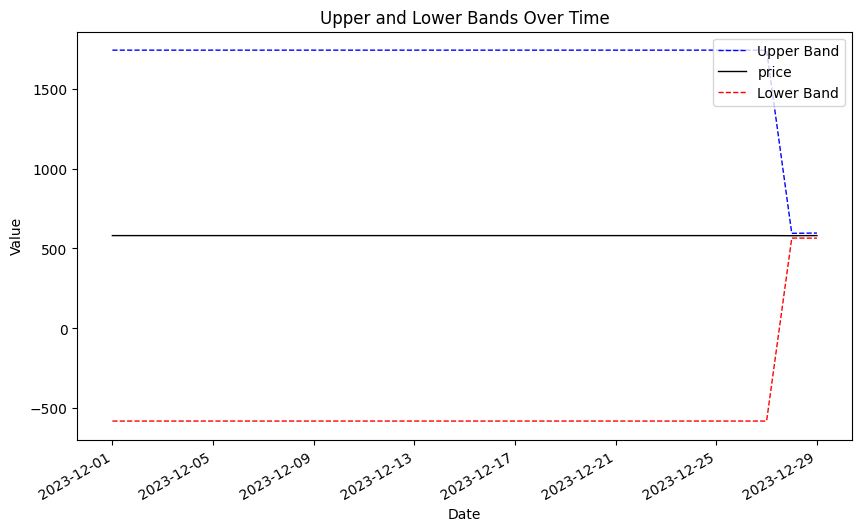

In [49]:
data['Date'] = pd.to_datetime(data['Date'])

# 设置图形大小
plt.figure(figsize=(10, 6))

# 绘制折线图
plt.plot(data['Date'], data['upperband'], marker='', color='blue', linewidth=1, linestyle='--', label='Upper Band')
plt.plot(data['Date'], data['ma'], marker='', color='black', linewidth=1, label='price')
plt.plot(data['Date'], data['lowerband'], marker='', color='red', linewidth=1, linestyle='--', label='Lower Band')

# 添加标题和标签
plt.title('Upper and Lower Bands Over Time')
plt.xlabel('Date')
plt.ylabel('Value')

# 添加图例
plt.legend()

# 自动调整日期显示格式
plt.gcf().autofmt_xdate()

# 显示图形
plt.show()

## K線圖

c:\Users\user\miniconda3\envs\vene1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\envs\vene1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\envs\vene1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26681 (\N{CJK UNIFIED IDEOGRAPH-6839}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\envs\vene1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\envs\vene1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 28072 (\N{CJK U

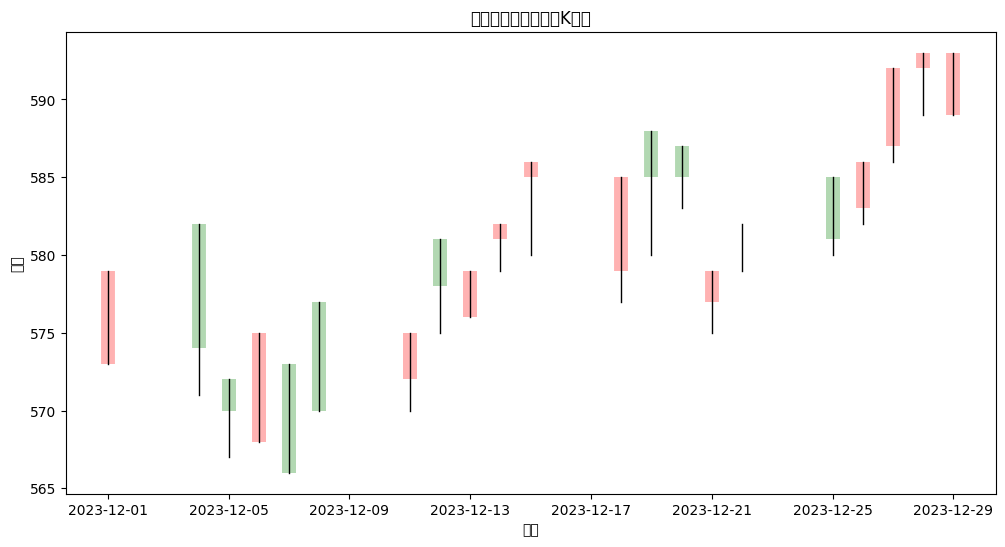

In [50]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd


# 将 Date 列转换为日期时间格式
data['Date'] = pd.to_datetime(data['Date'])

# 设置图形大小
plt.figure(figsize=(12, 6))

# 绘制K线图
for index, row in data.iterrows():
    date = row['Date']
    open_price = row['Open']
    close_price = row['Close']
    high_price = row['High']
    low_price = row['Low']
    
    if close_price >= open_price:
        # 涨：最高价 - 收盘价 和 开盘价 - 最低价 的填充为红色
        plt.fill([date, date, date], [high_price, close_price, open_price], 'red', edgecolor='red', linewidth=10, alpha=0.3)
        plt.plot([date, date], [low_price, high_price], color='black', linewidth=1)
    else:
        # 跌：最高价 - 开盘价 和 收盘价 - 最低价 的填充为绿色
        plt.fill([date, date, date], [high_price, open_price, close_price], 'green', edgecolor='green', linewidth=10, alpha=0.3)
        plt.plot([date, date], [low_price, high_price], color='black', linewidth=1)

# 设置x轴日期显示格式
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# 添加标题和标签
plt.title('根据涨跌情况填充的K线图')
plt.xlabel('日期')
plt.ylabel('价格')

# 显示图形
plt.show()


In [119]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 读取数据
# data = pd.read_csv('data.csv')
data = pd.read_csv('data2023.csv')
data =data.iloc[30:].reset_index(drop=True)

c:\Users\user\miniconda3\envs\vene1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\envs\vene1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\envs\vene1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\envs\vene1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25240 (\N{CJK UNIFIED IDEOGRAPH-6298}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\envs\vene1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26085 (\N{CJK U

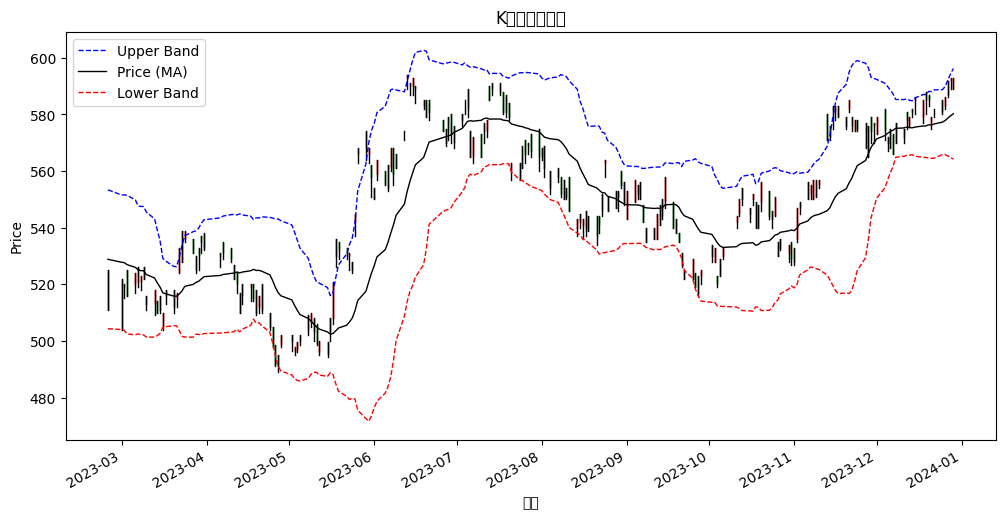

In [121]:


# 将 Date 列转换为日期时间格式
data['Date'] = pd.to_datetime(data['Date'])

# 设置图形大小
plt.figure(figsize=(12, 6))

# 绘制K线图
for index, row in data.iterrows():
    date = row['Date']
    open_price = row['Open']
    close_price = row['Close']
    high_price = row['High']
    low_price = row['Low']
    
    if close_price >= open_price:
        # 涨：最高价 - 收盘价 和 开盘价 - 最低价 的填充为红色
        plt.fill([date, date, date], [high_price, close_price, open_price], 'red', edgecolor='red', linewidth=2, alpha=0.3)
        plt.plot([date, date], [low_price, high_price], color='black', linewidth=1)
    else:
        # 跌：最高价 - 开盘价 和 收盘价 - 最低价 的填充为绿色
        plt.fill([date, date, date], [high_price, open_price, close_price], 'green', edgecolor='green', linewidth=2, alpha=0.3)
        plt.plot([date, date], [low_price, high_price], color='black', linewidth=1)

# 绘制折线图
plt.plot(data['Date'], data['upperband'], marker='', color='blue', linewidth=1, linestyle='--', label='Upper Band')
plt.plot(data['Date'], data['ma'], marker='', color='black', linewidth=1, label='Price (MA)')
plt.plot(data['Date'], data['lowerband'], marker='', color='red', linewidth=1, linestyle='--', label='Lower Band')

# 设置标题和标签
plt.title('K线图与折线图')
plt.xlabel('日期')
plt.ylabel('Price')

# 添加图例
plt.legend()

# 自动调整日期显示格式
plt.gcf().autofmt_xdate()

# 显示图形
plt.show()

<Axes: >

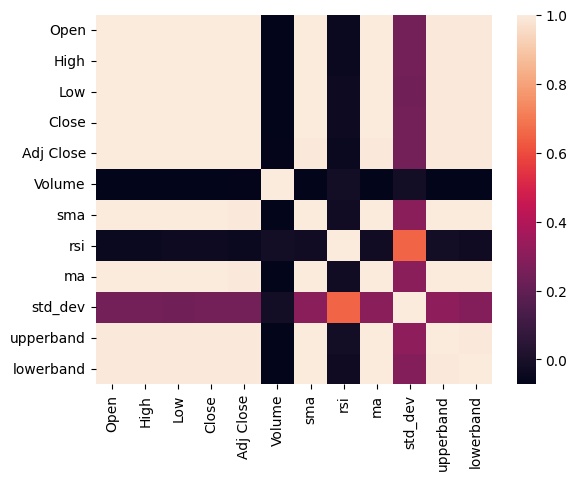

In [127]:
month_datas=data.drop(columns=['Date'])
sns.heatmap(month_datas.corr(method='pearson',min_periods=-1))

<Axes: >

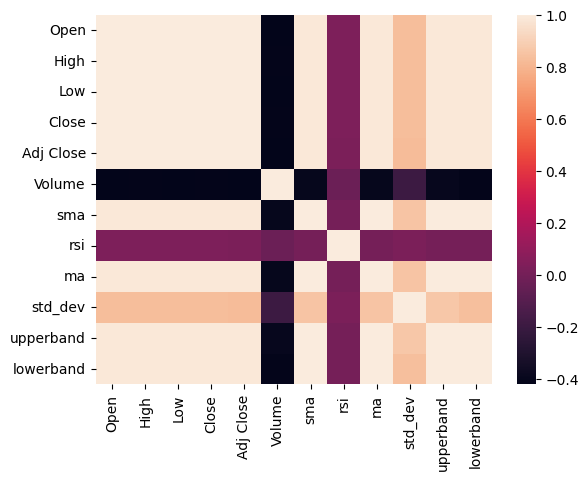

In [132]:
month_datas=data.drop(columns=['Date'])
sns.heatmap(month_datas.corr('spearman'))

In [135]:
month_datas=data.drop(columns=['Date'])
month_datas.corr('kendall')

ModuleNotFoundError: No module named 'scipy'

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data.csv')

print(df)

            Open        High         Low   Adj Close    Volume       sma  \
0      61.184048   61.877071   60.887035   34.932190  59821230   58.0407   
1      61.976074   62.867104   60.986038   34.484344  64072603   59.2584   
2      59.500992   60.095009   59.401985   33.980511  47462048   59.6049   
3      59.500992   62.372086   59.500992   35.212101  74207617   59.9713   
4      62.867104   62.867104   61.877071   35.436024  70510771   60.4217   
...          ...         ...         ...         ...       ...       ...   
2379  292.000000  292.500000  290.000000  267.696777  79774181  295.0250   
2380  294.000000  296.500000  293.500000  270.905518  35811214  295.0500   
2381  296.000000  297.500000  296.000000  271.822266  24771587  295.1000   
2382  300.000000  301.000000  298.000000  275.947754  65176337  295.3500   
2383  305.000000  306.000000  304.000000  280.531616  46572451  295.7750   

          rsi        ma  std_dev  upperband  lowerband       EMA12  \
0     65.7439   5

In [4]:
# 計算MACD指標的函數
def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    df['EMA12'] = df['Close'].ewm(span=short_window, min_periods=short_window, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=long_window, min_periods=long_window, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, min_periods=signal_window, adjust=False).mean()
    df['MACD_Histogram'] = df['MACD'] - df['Signal_Line']
    return df

# 調用計算MACD指標的函數
data = calculate_macd(df)

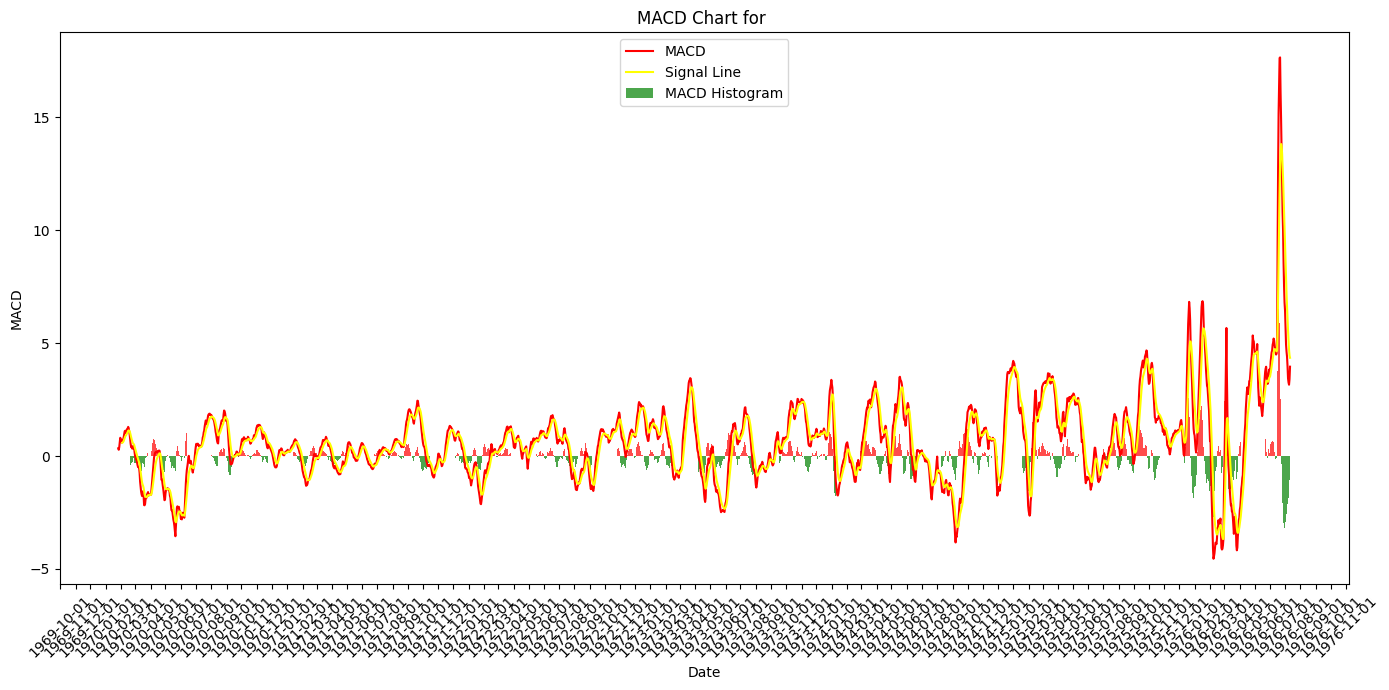

In [5]:
#MACD
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf  # 或者使用其他的金融資料源


# 繪製MACD圖表
plt.figure(figsize=(14, 7))

# 繪製快速線（MACD line），紅色
plt.plot(data.index, data['MACD'], color='red', label='MACD')

# 繪製信號線（Signal line），黃色
plt.plot(data.index, data['Signal_Line'], color='yellow', label='Signal Line')

# 繪製柱狀圖（Histogram），高為紅色，低為綠色
plt.bar(data.index, data['MACD_Histogram'], width=0.7, color=np.where(data['MACD_Histogram'] >= 0, 'red', 'green'), alpha=0.7, label='MACD Histogram')

# 添加圖表元素和標籤
plt.title('MACD Chart for ')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()

# 設置x軸為時間格式
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

# 顯示圖表
plt.tight_layout()
plt.show()

In [17]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import chi2

In [13]:
df = data.iloc[:, :-1]
df

,Open,High,Low,Adj Close,Volume,sma,rsi,ma,std_dev,upperband,lowerband,EMA12,EMA26,MACD,Signal_Line,MACD_Histogram
0,61.184048,61.877071,60.887035,34.932190,59821230,58.0407,65.7439,58.0407,3.8147,65.6701,50.4113,60.024440,58.772403,1.252037,1.071421,0.180617
1,61.976074,62.867104,60.986038,34.484344,64072603,59.2584,69.6296,59.2584,2.7428,64.7440,53.7728,60.555317,59.224010,1.331307,1.175004,0.156303
2,59.500992,60.095009,59.401985,33.980511,47462048,59.6049,63.8889,59.6049,2.3407,64.2863,54.9235,60.484501,59.288528,1.195972,1.179197,0.016775
3,59.500992,62.372086,59.500992,35.212101,74207617,59.9713,64.4531,59.9713,2.1379,64.2471,55.6955,60.759667,59.509607,1.250060,1.193370,0.056690
4,62.867104,62.867104,61.877071,35.436024,70510771,60.4217,68.4211,60.4217,1.6259,63.6735,57.1699,61.053426,59.743643,1.309783,1.216653,0.093130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2379,292.000000,292.500000,290.000000,267.696777,79774181,295.0250,40.0000,295.0250,2.7313,300.4876,289.5624,294.222902,294.054377,0.168525,0.623369,-0.454844
2380,294.000000,296.500000,293.500000,270.905518,35811214,295.0500,50.4425,295.0500,2.7333,300.5166,289.5834,294.419378,294.161460,0.257918,0.550279,-0.292360
2381,296.000000,297.500000,296.000000,271.822266,24771587,295.1000,50.8772,295.1000,2.7511,300.6022,289.5978,294.739474,294.334685,0.404789,0.521181,-0.116392
2382,300.000000,301.000000,298.000000,275.947754,65176337,295.3500,54.0984,295.3500,3.0483,301.4466,289.2534,295.702632,294.828412,0.874220,0.591788,0.282431


In [14]:
target = data.iloc[:, -1]
target

0        61.778069
1        60.986038
2        60.095009
3        62.273083
4        62.669098
           ...    
2379    292.000000
2380    295.500000
2381    296.500000
2382    301.000000
2383    306.000000
Name: Close, Length: 2384, dtype: float64

In [18]:
n = 16
chi = SelectKBest(f_regression, k=n)
arrchi = chi.fit_transform(data, target)
arrchi

array([[ 6.11840477e+01,  6.18770714e+01,  6.08870354e+01, ...,
         1.25203723e+00,  1.07142065e+00,  1.80616587e-01],
       [ 6.19760742e+01,  6.28671036e+01,  6.09860382e+01, ...,
         1.33130720e+00,  1.17500370e+00,  1.56303500e-01],
       [ 5.95009918e+01,  6.00950089e+01,  5.94019852e+01, ...,
         1.19597210e+00,  1.17919738e+00,  1.67747139e-02],
       ...,
       [ 2.96000000e+02,  2.97500000e+02,  2.96000000e+02, ...,
         4.04788681e-01,  5.21180670e-01, -1.16391989e-01],
       [ 3.00000000e+02,  3.01000000e+02,  2.98000000e+02, ...,
         8.74219513e-01,  5.91788439e-01,  2.82431074e-01],
       [ 3.05000000e+02,  3.06000000e+02,  3.04000000e+02, ...,
         1.63090499e+00,  7.99611748e-01,  8.31293237e-01]])

In [19]:
score = chi.scores_
score

array([ 3.96626587e+06,  9.30238629e+06,  1.06929360e+07,  5.76235679e+05,
        6.31444754e+02,  9.30596855e+05,  1.22763105e+01,  9.30596855e+05,
        1.86552726e+03,  7.55676861e+05,  6.05395292e+05,  1.94754912e+06,
        9.43697872e+05,  1.36640729e+02,  1.35251761e+02,  3.12819792e+00,
       -1.78792905e+18])

In [20]:
scoresort = np.argsort(score)
scoresort = np.flipud(scoresort)
scoresort

array([ 2,  1,  0, 11, 12,  5,  7,  9, 10,  3,  8,  4, 13, 14,  6, 15, 16])

In [21]:
col = data.columns
print('選擇的特徵：')
for i in range(n):
  print('{}：{}'.format(col[scoresort[i]], score[scoresort[i]]))

選擇的特徵：
Low：10692935.981155252
High：9302386.290578613
Open：3966265.873988242
EMA12：1947549.1214738805
EMA26：943697.872354116
sma：930596.8552190585
ma：930596.8552190585
upperband：755676.8611111915
lowerband：605395.2919562279
Adj Close：576235.6786808618
std_dev：1865.5272602560565
Volume：631.4447536413743
MACD：136.64072926387607
Signal_Line：135.2517610689572
rsi：12.276310492076412
MACD_Histogram：3.12819791637063


In [25]:
col[scoresort[0:6]]

Index(['Low', 'High', 'Open', 'EMA12', 'EMA26', 'sma'], dtype='object')